# Imports

In [11]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [12]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [13]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [14]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [15]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

## Input/Output

In [36]:
# save a dictionary as a csv file
def output_as_csv(name, a):
    path = "/kaggle/working/" + name + ".csv"
    with open(path, 'w') as csv_file:
        # create the csv writer
        writer = csv.writer(csv_file)

        # write a row to the csv file
        writer.writerow(a.keys())
        writer.writerow(a.values())

# input a csv file
def input_csv(path):
    b, keys = {}, {}
    with open(path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            keys = row
    b = dict(keys)
    return b # returns a dictionary

# Pre-Process DataSet

In [37]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [38]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

In [40]:
# returns the confusion matrix
def find_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_val = y_pred.argmax(axis=1)
    y_test_val = y_test.argmax(axis=1)
    return confusion_matrix(y_test_val, y_pred_val)

# returns the confusion matrix based on tn, fn, fp, tp
def find_confusion_matrix_2(tn, fn, fp, tp):
    return [[tn, fp], [fn, tp]]

# generate heat map for confusion matrix
def heatmap(confusion_matrix):
    df = pd.DataFrame(confusion_matrix, index = ['F', 'T'], columns = ['F', 'T'])
    sn.heatmap(df, annot=True) # create a heatmap
    
# returns normalized confusion matrix
def normalize_confusion_matrix(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    confusion_matrix_sum = confusion_matrix.astype(np.float).sum(axis=1)
    confusion_matrix_norm = confusion_matrix.astype(np.float)
    confusion_matrix_norm[0] = confusion_matrix_norm[0] / confusion_matrix_sum[0]
    confusion_matrix_norm[1] = confusion_matrix_norm[1] / confusion_matrix_sum[1]
    return confusion_matrix_norm

def print_confusion_matrix_results(results):
    # results is a dictionary
    # calculate mean and standard deviation for each key
    for key in results:
        mean = np.mean(results[key])
        std = np.std(results[key])
        print("{} mean: {}".format(key, mean))
        print("{} std: {}".format(key, std))

# Create CNN Model

In [20]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Batch Normalization

In [ ]:
# define cnn model
def define_model_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Dropout Regularization

In [ ]:
# define cnn model
def define_model_dropout_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Dropout Regularization and Batch Normalization*

In [ ]:
# define cnn model
def define_model_dropout_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [ ]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Weight Regularization and Batch Normalization

In [ ]:
# define cnn model
def define_model_weight_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [21]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [17]:
model, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

Epoch 1/75
157/157 [==============================] - 638s 4s/step - loss: 0.6564 - accuracy: 0.6002 - val_loss: 0.4845 - val_accuracy: 0.8140
Epoch 2/75
157/157 [==============================] - 625s 4s/step - loss: 0.4794 - accuracy: 0.8072 - val_loss: 0.4130 - val_accuracy: 0.8320
Epoch 3/75
157/157 [==============================] - 638s 4s/step - loss: 0.4021 - accuracy: 0.8461 - val_loss: 0.3599 - val_accuracy: 0.8645
Epoch 4/75
157/157 [==============================] - 640s 4s/step - loss: 0.3156 - accuracy: 0.8779 - val_loss: 0.3943 - val_accuracy: 0.8360
Epoch 5/75
157/157 [==============================] - 634s 4s/step - loss: 0.2886 - accuracy: 0.8891 - val_loss: 0.2182 - val_accuracy: 0.9170
Epoch 6/75
157/157 [==============================] - 631s 4s/step - loss: 0.2169 - accuracy: 0.9160 - val_loss: 0.2075 - val_accuracy: 0.9205
Epoch 7/75
157/157 [==============================] - 630s 4s/step - loss: 0.1817 - accuracy: 0.9299 - val_loss: 0.1846 - val_accuracy: 0.9285

KeyboardInterrupt: 

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data w/ Cross Validation

In [22]:
def benchmark_model(X_all, y_all, split):
    X_train_cv, y_train_cv = X_all[split[0]], y_all[split[0]]
    X_val_cv, y_val_cv = X_all[split[1]], y_all[split[1]]
    model, accuracy = train(X_train_cv, X_val_cv, X_val_cv, y_train_cv, y_val_cv, y_val_cv, 0.001, 75) 
    results = {}
    results["model"] = model
    results["accuracy"] = accuracy
    results["confusion_matrix"] = find_confusion_matrix(model, X_val_cv, y_val_cv)
    tn, fp, fn, tp = results["confusion_matrix"].ravel()
    results["tn"] = tn
    results["fp"] = fp
    results["fn"] = fn
    results["tp"] = tp
    results["TPR/Recall"] = tp/(tp+fn)
    results["TNR/Specificity"] = tn/(tn+fp)
    results["PPV/Precision"] = tp/(tp+fp)
    results["NPV"] = tn/(tn+fn)
    return results

In [32]:
kf = KFold(n_splits=5)
folds = list(kf.split(X_all, y_all))

Epoch 1/75
150/150 [==============================] - 618s 4s/step - loss: 0.6321 - accuracy: 0.6259 - val_loss: 0.5918 - val_accuracy: 0.6858
Epoch 2/75
150/150 [==============================] - 592s 4s/step - loss: 0.5072 - accuracy: 0.7715 - val_loss: 0.4019 - val_accuracy: 0.8421
Epoch 3/75
150/150 [==============================] - 593s 4s/step - loss: 0.4061 - accuracy: 0.8406 - val_loss: 0.4029 - val_accuracy: 0.8587
Epoch 4/75
150/150 [==============================] - 591s 4s/step - loss: 0.3777 - accuracy: 0.8544 - val_loss: 0.3268 - val_accuracy: 0.8746
Epoch 5/75
150/150 [==============================] - 592s 4s/step - loss: 0.3247 - accuracy: 0.8777 - val_loss: 0.4780 - val_accuracy: 0.7954
Epoch 6/75
150/150 [==============================] - 595s 4s/step - loss: 0.3064 - accuracy: 0.8807 - val_loss: 0.2810 - val_accuracy: 0.8867
Epoch 7/75
150/150 [==============================] - 599s 4s/step - loss: 0.2554 - accuracy: 0.8998 - val_loss: 0.2414 - val_accuracy: 0.9067

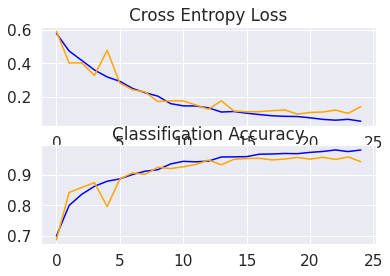

In [19]:
output_as_csv("normal_fold_1", benchmark_model(X_all, y_all, folds[0]))

Epoch 1/75
150/150 [==============================] - 539s 4s/step - loss: 0.6625 - accuracy: 0.5875 - val_loss: 0.5650 - val_accuracy: 0.7896
Epoch 2/75
150/150 [==============================] - 538s 4s/step - loss: 0.5218 - accuracy: 0.7837 - val_loss: 0.4588 - val_accuracy: 0.8346
Epoch 3/75
150/150 [==============================] - 534s 4s/step - loss: 0.4175 - accuracy: 0.8375 - val_loss: 0.3848 - val_accuracy: 0.8462
Epoch 4/75
150/150 [==============================] - 538s 4s/step - loss: 0.3651 - accuracy: 0.8568 - val_loss: 0.4427 - val_accuracy: 0.8238
Epoch 5/75
150/150 [==============================] - 538s 4s/step - loss: 0.3210 - accuracy: 0.8747 - val_loss: 0.3361 - val_accuracy: 0.8612
Epoch 6/75
150/150 [==============================] - 541s 4s/step - loss: 0.2843 - accuracy: 0.8853 - val_loss: 0.2986 - val_accuracy: 0.8733
Epoch 7/75
150/150 [==============================] - 536s 4s/step - loss: 0.2589 - accuracy: 0.8946 - val_loss: 0.3137 - val_accuracy: 0.8792

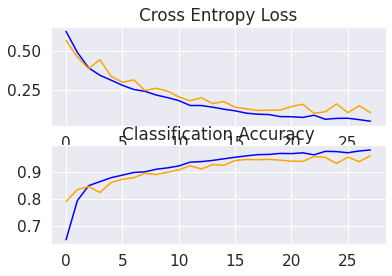

In [15]:
output_as_csv("normal_fold_2", benchmark_model(X_all, y_all, folds[1]))

Epoch 1/75
150/150 [==============================] - 588s 4s/step - loss: 0.6399 - accuracy: 0.6165 - val_loss: 0.5825 - val_accuracy: 0.6804
Epoch 2/75
150/150 [==============================] - 593s 4s/step - loss: 0.4735 - accuracy: 0.8031 - val_loss: 0.4286 - val_accuracy: 0.8271
Epoch 3/75
150/150 [==============================] - 597s 4s/step - loss: 0.4074 - accuracy: 0.8316 - val_loss: 0.3614 - val_accuracy: 0.8587
Epoch 4/75
150/150 [==============================] - 594s 4s/step - loss: 0.3420 - accuracy: 0.8656 - val_loss: 0.3273 - val_accuracy: 0.8654
Epoch 5/75
150/150 [==============================] - 597s 4s/step - loss: 0.3094 - accuracy: 0.8685 - val_loss: 0.2986 - val_accuracy: 0.8767
Epoch 6/75
150/150 [==============================] - 594s 4s/step - loss: 0.2774 - accuracy: 0.8893 - val_loss: 0.2498 - val_accuracy: 0.8971
Epoch 7/75
150/150 [==============================] - 600s 4s/step - loss: 0.2356 - accuracy: 0.9016 - val_loss: 0.2414 - val_accuracy: 0.8963

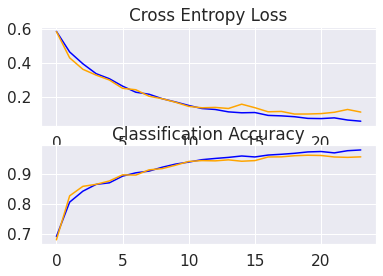

In [21]:
output_as_csv("normal_fold_3", benchmark_model(X_all, y_all, folds[2]))

Epoch 1/75
150/150 [==============================] - 545s 4s/step - loss: 0.6866 - accuracy: 0.6027 - val_loss: 0.4911 - val_accuracy: 0.7983
Epoch 2/75
150/150 [==============================] - 526s 4s/step - loss: 0.5107 - accuracy: 0.7720 - val_loss: 0.4028 - val_accuracy: 0.8487
Epoch 3/75
150/150 [==============================] - 520s 3s/step - loss: 0.4508 - accuracy: 0.8187 - val_loss: 0.3931 - val_accuracy: 0.8508
Epoch 4/75
150/150 [==============================] - 514s 3s/step - loss: 0.3938 - accuracy: 0.8435 - val_loss: 0.3278 - val_accuracy: 0.8792
Epoch 5/75
150/150 [==============================] - 512s 3s/step - loss: 0.3524 - accuracy: 0.8611 - val_loss: 0.3060 - val_accuracy: 0.8846
Epoch 6/75
150/150 [==============================] - 514s 3s/step - loss: 0.3199 - accuracy: 0.8794 - val_loss: 0.2853 - val_accuracy: 0.8975
Epoch 7/75
150/150 [==============================] - 517s 3s/step - loss: 0.2730 - accuracy: 0.8969 - val_loss: 0.2504 - val_accuracy: 0.9021

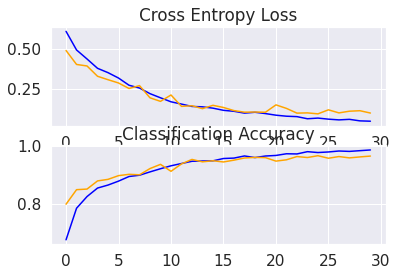

In [17]:
output_as_csv("normal_fold_4", benchmark_model(X_all, y_all, folds[3]))

Epoch 1/75
150/150 [==============================] - 585s 4s/step - loss: 0.6688 - accuracy: 0.5712 - val_loss: 0.5812 - val_accuracy: 0.6938
Epoch 2/75
150/150 [==============================] - 588s 4s/step - loss: 0.5244 - accuracy: 0.7551 - val_loss: 0.4633 - val_accuracy: 0.7958
Epoch 3/75
150/150 [==============================] - 586s 4s/step - loss: 0.4547 - accuracy: 0.8031 - val_loss: 0.3901 - val_accuracy: 0.8433
Epoch 4/75
150/150 [==============================] - 582s 4s/step - loss: 0.3944 - accuracy: 0.8473 - val_loss: 0.3364 - val_accuracy: 0.8767
Epoch 5/75
150/150 [==============================] - 586s 4s/step - loss: 0.3388 - accuracy: 0.8619 - val_loss: 0.2885 - val_accuracy: 0.8871
Epoch 6/75
150/150 [==============================] - 582s 4s/step - loss: 0.2839 - accuracy: 0.8882 - val_loss: 0.3809 - val_accuracy: 0.8375
Epoch 7/75
150/150 [==============================] - 579s 4s/step - loss: 0.2850 - accuracy: 0.8821 - val_loss: 0.2089 - val_accuracy: 0.9192

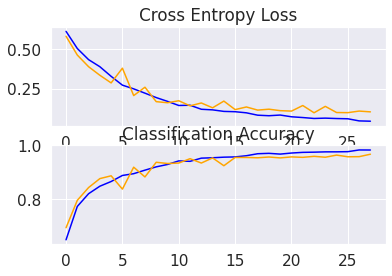

In [16]:
output_as_csv("normal_fold_5", benchmark_model(X_all, y_all, folds[4]))

In [26]:
# results_list is a list of dictionaries
results_list = []
for i in range(1,6):
    path = "../input/hurricane-normal-cv/normal_fold_" + str(i) + ".csv"
    results_list.append(input_csv(path))

# results_dict is a dictionary of lists
results_dict = {}
results_dict["accuracy"] = [(float)(i["accuracy"]) for i in results_list]
results_dict["TPR/Recall"] = [(float)(i["TPR/Recall"]) for i in results_list]
results_dict["TNR/Specificity"] = [(float)(i["TNR/Specificity"]) for i in results_list]
results_dict["PPV/Precision"] = [(float)(i["PPV/Precision"]) for i in results_list]
results_dict["NPV"] = [(float)(i["NPV"]) for i in results_list]

print_confusion_matrix_results(results_dict)

accuracy mean: 0.9590000033378601
accuracy std: 0.00842283846461883
TPR/Recall mean: 0.9655303619616333
TPR/Recall std: 0.015680085653996888
TNR/Specificity mean: 0.9523902512358335
TNR/Specificity std: 0.028580426132611525
PPV/Precision mean: 0.9532846910207298
PPV/Precision std: 0.025046205779798367
NPV mean: 0.9665429223506573
NPV std: 0.014134516279085218


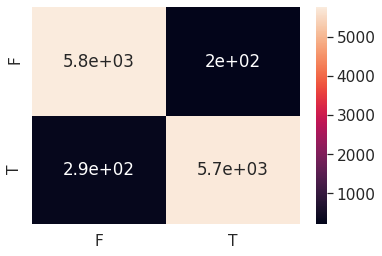

In [34]:
# find confusion matrices
results_dict["tn"] = [(int)(i["tn"]) for i in results_list]
results_dict["fp"] = [(int)(i["fp"]) for i in results_list]
results_dict["fn"] = [(int)(i["fn"]) for i in results_list]
results_dict["tp"] = [(int)(i["tp"]) for i in results_list]
results_dict["confusion_matrix"] = []
# append confusion matrix for each cross-validation fold
for i in range(len(folds)):
    results_dict["confusion_matrix"].append(find_confusion_matrix_2(results_dict["tn"][i], results_dict["fp"][i], results_dict["fn"][i], results_dict["tp"][i]))
                                            
# total confusion matrix summed together
confusion_matrix_list = []
confusion_matrix_list = results_dict["confusion_matrix"]
confusion_matrix_comb = np.sum(confusion_matrix_list, axis=0)
heatmap(confusion_matrix_comb)

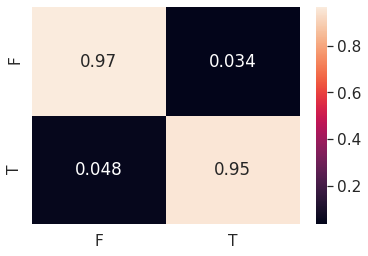

In [41]:
# normalized confusion matrix
confusion_matrix_norm = normalize_confusion_matrix(confusion_matrix_comb)
heatmap(confusion_matrix_norm)

## Train Data with Batch Normalization

In [18]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [19]:
model, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

NameError: name 'define_model_batch_normalization' is not defined

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

## Train Data with Data Augmentation and Batch Normalization

In [ ]:
def train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

In [ ]:
model_test_data_augmentation_batch_normalization, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_augmentation_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Dropout Regularization and Batch Normalization

In [ ]:
def train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_dropout_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization and Batch Normalization

In [ ]:
def train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))